In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

In [ ]:
import sys
import os
project_root= os.getcwd() + "/"

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import images_train_dir, images_val_dir, artifacts_dir, labels_2_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, filter_valid_bboxes, calculate_iou, assign_targets_to_anchors, sample_minibatch, create_bbox_deltas, apply_deltas_to_boxes, clamp_boxes_to_img_boundary, filter_proposals
from utils import visualize_anchors_and_gt

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")

# print("Path to dataset files:", path)

In [4]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['9457c96f65dbd001.jpg',
 'b5f1257e99d7954e.jpg',
 'c03459213c821414.jpg',
 '216fdb22abf4ba01.jpg']

In [5]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= config.labels_2_dir, image_list= train_images, transform= transforms)
train_dataset[1]['image'].shape

torch.Size([3, 512, 512])

In [6]:
vgg16= models.vgg16(pretrained= True)
backbone= vgg16.features[:-1]
for p in backbone.parameters():
    p.requires_grad= False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
sample_image= train_dataset[0]['image']
sample_label= train_dataset[0]['boxes']
features= backbone(sample_image)
all_anchors= generate_anchor_boxes(sample_image.shape[-2:],
                                   features,
                                   config.ANCHOR_SCALES,
                                   config.ANCHOR_RATIOS)
print(f"Shape of all anchors: {all_anchors.shape}")

Shape of all anchors: torch.Size([15360, 4])


In [8]:
train_loader= DataLoader(train_dataset, batch_size= config.BATCH_SIZE, shuffle= True)

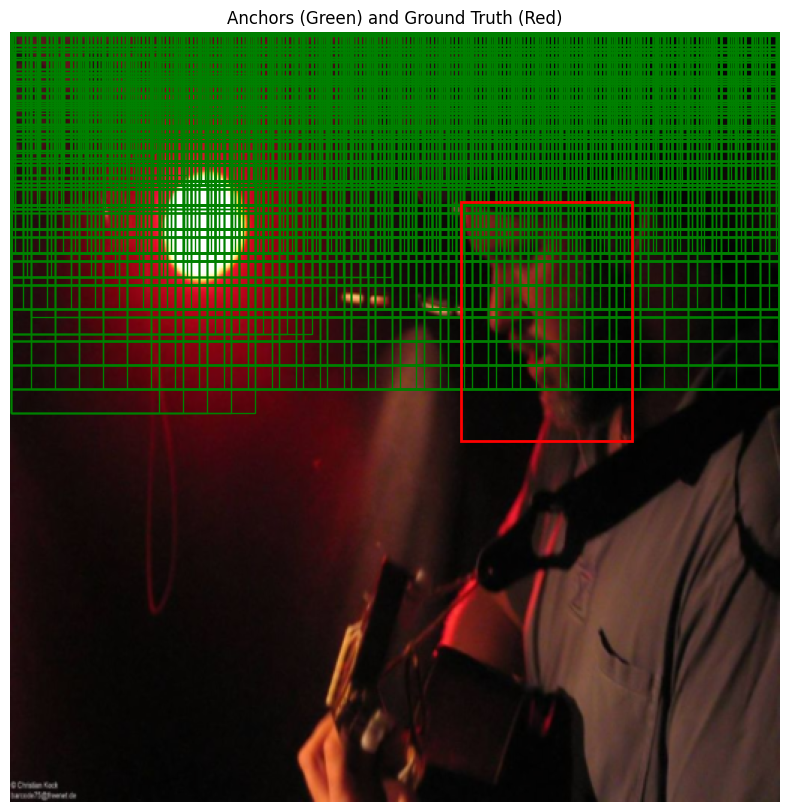

In [9]:
visualize_anchors_and_gt(sample_image, all_anchors[100:2000], sample_label)

In [10]:
filtered_bboxes= filter_valid_bboxes(sample_label)
iou= calculate_iou(all_anchors, filtered_bboxes)
all_anchors.shape, iou.shape, filtered_bboxes.shape

(torch.Size([15360, 4]), torch.Size([15360, 1]), torch.Size([1, 4]))

In [11]:
print(filtered_bboxes[0])

tensor([299.2000, 112.5335, 413.1999, 271.4665])


In [12]:
iou.max()

tensor(0.7329)

In [13]:
filtered_boxes= filter_valid_bboxes(sample_label)

In [14]:
labels, matched_gt_idx= assign_targets_to_anchors(all_anchors, sample_label)
pos_mask= labels == 1
labels[pos_mask].shape

torch.Size([7])

In [15]:
sampled_indices= sample_minibatch(labels)
sampled_indices

sampled_labels = labels[sampled_indices]


pos_mask_in_sample = (sampled_labels == 1)

sampled_anchors = all_anchors[sampled_indices]

positive_anchors = sampled_anchors[pos_mask_in_sample]

print(f"Shape of all sampled anchors: {sampled_anchors.shape}")
print(f"Shape of positive anchors only: {positive_anchors.shape}")

Shape of all sampled anchors: torch.Size([256, 4])
Shape of positive anchors only: torch.Size([7, 4])


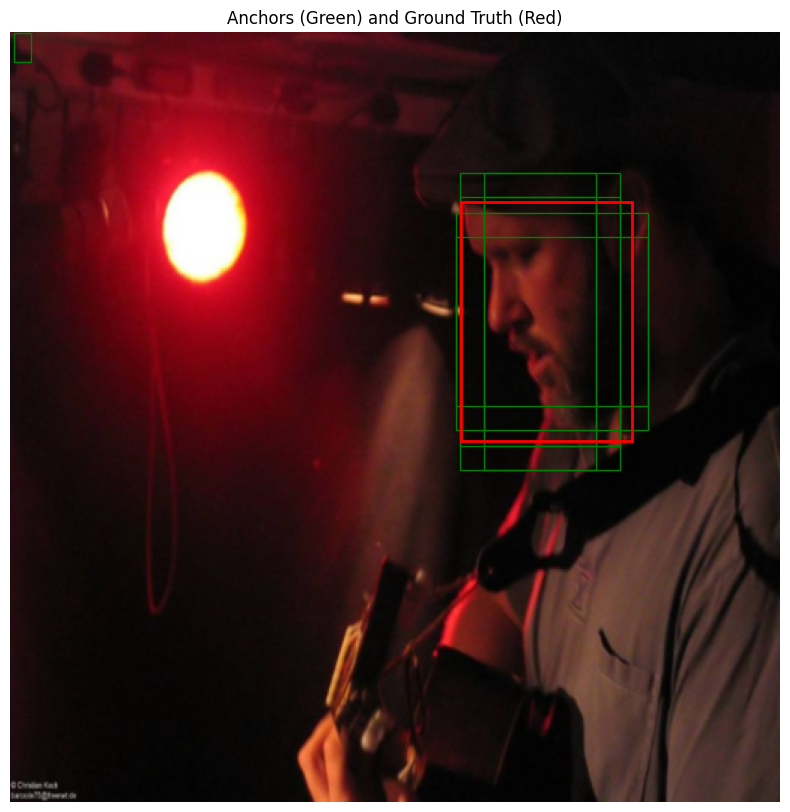

In [16]:
visualize_anchors_and_gt(sample_image, positive_anchors, filtered_bboxes)

In [17]:
def classification_loss(rpn_cls_logits, sampled_labels):
    targets= sampled_labels.float()
    logits= rpn_cls_logits.squeeze(-1)
    return F.binary_cross_entropy_with_logits(logits, targets)
def calculate_reg_loss(rpn_reg_deltas, target_deltas, sampled_labels):
    pos_mask= (sampled_labels == 1)

    predicted_deltas_for_positives= rpn_reg_deltas[pos_mask]
    target_deltas_for_positives= target_deltas[pos_mask]
    if predicted_deltas_for_positives.numel() == 0:
        return torch.tensor(0.0, device= rpn_reg_deltas.device)

    loss= F.smooth_l1_loss(predicted_deltas_for_positives,
                           target_deltas_for_positives,
                           beta= 1.0,
                           reduction= 'sum')
    return loss / len(sampled_labels)

In [18]:
class RPN(nn.Module):
    def __init__(self, in_channels= 512,
                 num_anchors_per_location= config.NUM_ANCHORS_PER_LOC,
                 pre_nms_topk= 1000,
                 post_nms_topk= 300,
                 scales= config.ANCHOR_SCALES,
                 aspect_ratios= config.ANCHOR_RATIOS,
                 nms_threshold= 0.7):  # 5 scales × 3 ratios
        super(RPN, self).__init__()
        self.num_anchors_per_loc= num_anchors_per_location
        self.rpn_conv= nn.Conv2d(in_channels,
                             in_channels, kernel_size= 3,
                             stride= 1, padding= 1)
        self.cls_layer= nn.Conv2d(in_channels,
                            num_anchors_per_location,
                            kernel_size= 1,
                            stride= 1)
        self.reg_layer= nn.Conv2d(in_channels,
                            self.num_anchors_per_loc * 4,
                            kernel_size= 1,
                            stride= 1)
        self.relu= nn.ReLU(inplace= True)

        for layer in [self.rpn_conv, self.cls_layer, self.reg_layer]:
            torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)

        # Hyperparams for proposal generation
        self.pre_nms_topk= pre_nms_topk
        self.post_nms_topk= post_nms_topk
        self.nms_threshold= nms_threshold
        self.scales= scales
        self.aspect_ratios= aspect_ratios
        self._anchor_cache= {}
    def _generate_anchors(self, features):
        B, _, H, W= features.shape
        key= (H, W)
        if key not in self._anchor_cache:
            anchors= generate_anchor_boxes(
                image_shape= (config.IMAGE_SIZE_RESHAPED[1], config.IMAGE_SIZE_RESHAPED[0]),
                features= features[0:1],
                anchor_scales= self.scales,
                anchor_ratios= self.aspect_ratios
            ).squeeze(0)
            self._anchor_cache[key]= anchors
        anchors= self._anchor_cache[key]
        return [anchors] * B

    def forward(self, feat, image_shapes, gt_boxes= None):

        B, C, H, W= feat.shape
        device= feat.device

        # 1. Shared conv heads
        rpn_features= self.relu(self.rpn_conv(feat)) # (B, C, H, W)
        cls_logits= self.cls_layer(rpn_features) # (B, A_per_loc, H, W)
        reg_deltas= self.reg_layer(rpn_features) # (B, A_per_loc * 4, H, W)

        A_per_loc= self.num_anchors_per_loc
        cls_logits= cls_logits.permute(0, 2, 3, 1).contiguous().view(B, -1)#(A, )
        reg_deltas= reg_deltas.permute(0, 2, 3, 1).contiguous().view(B, -1, 4) #(A, 4)

        # 2. Anchors (same for every image in batch)
        anchors_list= self._generate_anchors(feat)

        # 3. Loop over batch
        proposals_list, scores_list= [], []
        cls_list, reg_list, anchor_list= [], [], []

        # Training tensors
        sampled_cls_list, sampled_reg_list, sampled_labels_list, sampled_reg_targets_list= [], [], [], []

        for b in range(B):
            anchors= anchors_list[b].to(device)
            proposals= apply_deltas_to_boxes(anchors, reg_deltas[b])
            proposals= clamp_boxes_to_img_boundary(proposals, image_shapes[b])

            proposals, scores= filter_proposals(
                proposals,
                cls_logits[b],
                image_shapes[b],
                pre_nms_topk= self.pre_nms_topk,
                post_nms_topk= self.post_nms_topk,
                nms_thresh= self.nms_threshold
            )

            proposals_list.append(proposals)
            scores_list.append(scores)
            cls_list.append(cls_logits[b])
            reg_list.append(reg_deltas[b])
            anchor_list.append(anchors)

            if proposals.numel() == 0:
                continue

            # training targets
            if gt_boxes is not None:
                gt= filter_valid_bboxes(gt_boxes[b].to(device))
                if gt.numel() == 0:
                    continue

                labels, matched_gt_idx= assign_targets_to_anchors(anchors, gt)
                keep= sample_minibatch(labels)
                if keep.numel() == 0:
                    continue

                filtered_labels= labels[keep]
                reg_targets= create_bbox_deltas(anchors[keep], gt[matched_gt_idx[keep]])

                sampled_cls_list.append(cls_logits[b][keep])
                sampled_reg_list.append(reg_deltas[b][keep])
                sampled_labels_list.append(filtered_labels)
                sampled_reg_targets_list.append(reg_targets)

        if gt_boxes is not None and len(sampled_cls_list) == 0:
            zero= torch.tensor(0.0, device= device, requires_grad= True)
            return {
                "sampled_cls_logits": zero,
                "sampled_labels": zero,
                "sampled_reg_deltas": zero,
                "sampled_reg_targets": zero}

        out= {
            "proposals": proposals_list,
            "scores": scores_list,
            "cls_logits": cls_list,
            "reg_deltas": reg_list,
            "anchors": anchor_list,
        }

        if gt_boxes is not None and len(sampled_cls_list) > 0:
            out.update({
                "sampled_cls_logits": torch.cat(sampled_cls_list, 0),
                "sampled_reg_deltas": torch.cat(sampled_reg_list, 0),
                "sampled_labels": torch.cat(sampled_labels_list, 0),
                "sampled_reg_targets": torch.cat(sampled_reg_targets_list, 0),
            })
        return out

In [19]:
train_images, validation_images= train_test_split(all_images, test_size= 0.3, random_state= 42)
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= train_images, max_boxes= 10, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_2_dir, image_list= validation_images, max_boxes= 10, transform= transforms)
len(val_dataset)

4016

In [20]:
rpn_model= RPN()

In [21]:
train_loader= DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

In [22]:
def calculate_rpn_recall(
    proposals_per_image, gt_boxes_per_image, recall_threshold=0.5
):
    """
    Calculates the RPN recall for a batch of images.

    Args:
        proposals_per_image (list of Tensors): A list where each element is a tensor
                                               of proposals for one image.
        gt_boxes_per_image (list of Tensors): A list where each element is a tensor
                                              of ground-truth boxes for one image.
        recall_threshold (float): The IoU threshold to consider a GT box "recalled".

    Returns:
        tuple: A tuple containing (number of recalled GTs, total number of GTs).
    """
    total_recalled_gts = 0
    total_gts = 0

    for proposals, gt_boxes in zip(proposals_per_image, gt_boxes_per_image):
        gt_boxes = filter_valid_bboxes(gt_boxes)
        num_gt = len(gt_boxes)

        if num_gt == 0:
            continue  # No ground-truth boxes to recall for this image

        if len(proposals) == 0:
            total_gts += num_gt
            continue  # No proposals were generated, so recall is 0

        # Calculate IoU between all proposals and all GT boxes for this image
        iou_matrix = calculate_iou(proposals, gt_boxes)  # Shape: (num_proposals, num_gt)

        # For each GT box, find the highest IoU it has with any proposal
        max_iou_per_gt, _ = iou_matrix.max(dim=0)

        # Count how many GT boxes were successfully recalled
        recalled_count = (max_iou_per_gt >= recall_threshold).sum().item()

        total_recalled_gts += recalled_count
        total_gts += num_gt

    return total_recalled_gts, total_gts

In [23]:
optimizer= Adam(rpn_model.parameters(), lr= config.LEARNING_RATE)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss_history= []
val_loss_history= []
train_loss_per_epoch= 0.0
obj_loss_per_epoch= 0.0
reg_loss_per_epoch= 0.0
rpn_model.to(device)
backbone.to(device)
for epoch in range(config.NUM_EPOCHS):
    num_batches_epoch= 0.0
    rpn_model.train()
    for batch in train_loader:
        images= batch['image'].to(device)
        gt_boxes= [b.to(device) for b in batch['boxes']]
        B, _, H, W= images.shape

        image_shapes= [(H, W)] * B


        with torch.no_grad():
            features= backbone(images)
            features= features.to(device)

        rpn_out= rpn_model(features, image_shapes, gt_boxes= gt_boxes)

        cls_loss= classification_loss(rpn_out["sampled_cls_logits"], rpn_out["sampled_labels"])
        reg_loss= calculate_reg_loss(rpn_out["sampled_reg_deltas"],
                                     rpn_out["sampled_reg_targets"],
                                     rpn_out["sampled_labels"])
        loss= cls_loss + reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_per_epoch+= loss.item()
        obj_loss_per_epoch+= cls_loss.item()
        reg_loss_per_epoch+= reg_loss.item()
        num_batches_epoch+= 1
    train_loss_per_epoch/= num_batches_epoch
    obj_loss_per_epoch/= num_batches_epoch
    reg_loss_per_epoch/= num_batches_epoch
    print(f"Epoch: {epoch + 1} / {config.NUM_EPOCHS} | Train Obj Loss: {obj_loss_per_epoch:.4f} | Train Reg Loss: {reg_loss_per_epoch:.4f}")
    print(f"Total Train Loss: {train_loss_per_epoch:.4f}")

    rpn_model.eval()
    val_loss_per_epoch= 0.0
    val_obj_loss_per_epoch= 0.0
    val_reg_loss_per_epoch= 0.0
    num_val_batches= 0
    total_recalled, total_gts= 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images= batch['image'].to(device)
            gt_boxes= [b.to(device) for b in batch['boxes']]

            B, _, H, W= images.shape
            image_shapes= [(H, W)] * B

            features= backbone(images)
            features= features.to(device)


            rpn_out= rpn_model(features, image_shapes, gt_boxes= gt_boxes)

            cls_loss= classification_loss(rpn_out["sampled_cls_logits"], rpn_out["sampled_labels"])
            reg_loss= calculate_reg_loss(rpn_out["sampled_reg_deltas"],
                                         rpn_out["sampled_reg_targets"],
                                         rpn_out["sampled_labels"])
            loss= cls_loss + reg_loss

            val_loss_per_epoch+= loss.item()
            val_obj_loss_per_epoch+= cls_loss.item()
            val_reg_loss_per_epoch+= reg_loss.item()
            num_val_batches+= 1

            recalled, gts= calculate_rpn_recall(rpn_out["proposals"], gt_boxes)
            total_recalled+= recalled
            total_gts+= gts
        overall_recall= total_recalled / total_gts
        print(f"Overall Val Recall: {overall_recall:.4f}")
    val_loss_per_epoch/= num_val_batches
    val_obj_loss_per_epoch/= num_val_batches
    val_reg_loss_per_epoch/= num_val_batches

    train_loss_history.append(train_loss_per_epoch)
    val_loss_history.append(val_loss_per_epoch)
    print(f"Epoch: {epoch + 1} / {config.NUM_EPOCHS} | Val Obj Loss: {val_obj_loss_per_epoch:.4f} | Val Reg Loss: {val_reg_loss_per_epoch:.4f}")
    print(f"Total Val Loss: {val_loss_per_epoch:.4f}")
    print("-"*50)

Epoch: 1 / 5 | Train Obj Loss: 0.0851 | Train Reg Loss: 0.0014
Total Train Loss: 0.0864
Overall Val Recall: 0.7745
Epoch: 1 / 5 | Val Obj Loss: 0.0341 | Val Reg Loss: 0.0011
Total Val Loss: 0.0352
--------------------------------------------------
Epoch: 2 / 5 | Train Obj Loss: 0.0314 | Train Reg Loss: 0.0011
Total Train Loss: 0.0325
Overall Val Recall: 0.7979
Epoch: 2 / 5 | Val Obj Loss: 0.0292 | Val Reg Loss: 0.0011
Total Val Loss: 0.0303
--------------------------------------------------
Epoch: 3 / 5 | Train Obj Loss: 0.0271 | Train Reg Loss: 0.0010
Total Train Loss: 0.0281
Overall Val Recall: 0.8053
Epoch: 3 / 5 | Val Obj Loss: 0.0275 | Val Reg Loss: 0.0011
Total Val Loss: 0.0286
--------------------------------------------------
Epoch: 4 / 5 | Train Obj Loss: 0.0245 | Train Reg Loss: 0.0009
Total Train Loss: 0.0254
Overall Val Recall: 0.8082
Epoch: 4 / 5 | Val Obj Loss: 0.0267 | Val Reg Loss: 0.0011
Total Val Loss: 0.0278
--------------------------------------------------
Epoch: 5

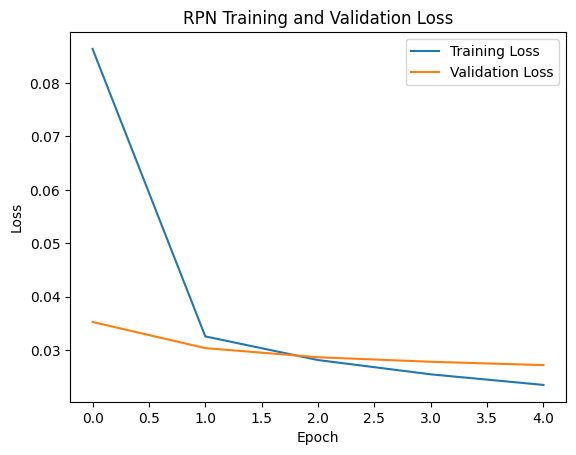

In [24]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()

In [25]:
all_test_images= [
    img for img in os.listdir(images_val_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_2_dir, img.rsplit('.', 1)[0] + ".txt"))
]
test_dataset= FaceDataset(image_dir= images_val_dir, label_dir= labels_2_dir, image_list= all_test_images, transform= transforms)
test_loader= DataLoader(test_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

In [ ]:
rpn_model.eval()
backbone.eval()
test_loss_history= []
test_loss_per_epoch= 0.0
test_obj_loss_per_epoch= 0.0
test_reg_loss_per_epoch= 0.0
num_test_batches= 0
total_recalled, total_gts= 0, 0
for epoch in range(1):
    with torch.no_grad():
          for batch in test_loader:
              images= batch['image'].to(device)
              gt_boxes= [b.to(device) for b in batch['boxes']]

              B, _, H, W= images.shape
              image_shapes= [(H, W)] * B

              features= backbone(images)
              features= features.to(device)


              rpn_out= rpn_model(features, image_shapes, gt_boxes= gt_boxes)

              cls_loss= classification_loss(rpn_out["sampled_cls_logits"], rpn_out["sampled_labels"])
              reg_loss= calculate_reg_loss(rpn_out["sampled_reg_deltas"],
                                            rpn_out["sampled_reg_targets"],
                                            rpn_out["sampled_labels"])
              loss= cls_loss + reg_loss

              test_loss_per_epoch+= loss.item()
              test_obj_loss_per_epoch+= cls_loss.item()
              test_reg_loss_per_epoch+= reg_loss.item()
              num_test_batches+= 1

              recalled, gts= calculate_rpn_recall(rpn_out["proposals"], gt_boxes)
              total_recalled+= recalled
              total_gts+= gts
          overall_recall= total_recalled / total_gts
          print(f"Overall Test Recall: {overall_recall:.4f}")
    test_loss_per_epoch/= num_test_batches
    test_obj_loss_per_epoch/= num_test_batches
    test_reg_loss_per_epoch/= num_test_batches

    train_loss_history.append(train_loss_per_epoch)
    test_loss_history.append(test_loss_per_epoch)
    print(f"Epoch: {epoch + 1} / {config.NUM_EPOCHS} | Test Obj Loss: {test_obj_loss_per_epoch:.4f} | Test Reg Loss: {test_reg_loss_per_epoch:.4f}")
    print(f"Total test Loss: {test_loss_per_epoch:.4f}")
    print("-"*50)

Overall Test Recall: 0.7855
Epoch: 1 / 5 | Test Obj Loss: 0.0289 | Test Reg Loss: 0.0012
Total test Loss: 0.0302
--------------------------------------------------


torch.Size([1, 512, 32, 32])
Number of proposals: 300
Proposals score range: 0.053 - 0.943
Recall @0.5: 0.750


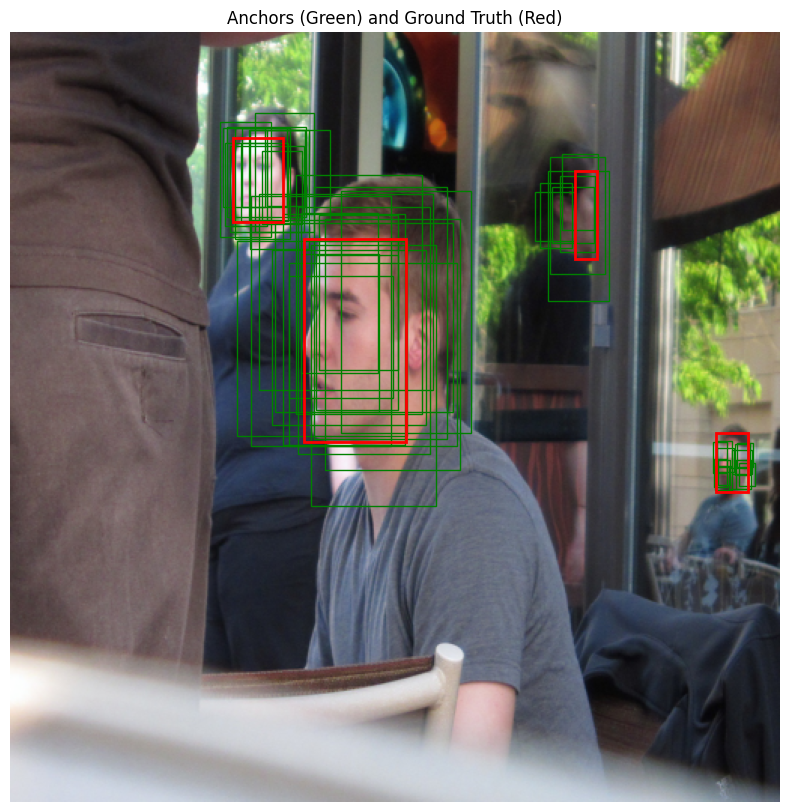

In [ ]:
sample_image= test_dataset[4]['image'].unsqueeze(0)
sample_label= test_dataset[4]['boxes']
gt_boxes= filter_valid_bboxes(sample_label.to(device))
sample_image_shapes= [(sample_image.shape[2], sample_image.shape[3])]

with torch.no_grad():
    features= backbone(sample_image.to(device))
print(features.shape)
rpn_out= rpn_model(features, sample_image_shapes, gt_boxes= None)
proposals= rpn_out["proposals"][0]
scores= rpn_out["scores"][0]

print(f"Number of proposals: {len(proposals)}")
print(f"Proposals score range: {scores.min().item():.3f} - {scores.max().item():.3f}")

if len(gt_boxes) > 0:
    iou_matrix= calculate_iou(proposals, gt_boxes)
    max_iou_per_gt, _= iou_matrix.max(dim=0)
    recall= (max_iou_per_gt >= 0.5).float().mean().item()
    print(f"Recall @0.5: {recall:.3f}")

visualize_anchors_and_gt(sample_image.squeeze(0), proposals[:50].detach().cpu(), gt_boxes.detach().cpu())

In [28]:
torch.save(rpn_model, artifacts_dir + "rpn_5epchs_vgg16bb_scales_ratios_1_lr1e-4_bs16.pth")

In [29]:
torch.save(rpn_model.state_dict(), artifacts_dir + "rpn_5epchs_vgg16bb_scales_ratios_1_lr1e-4_wghts_bs16.pth")